# Compare ML Models

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgbm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.decomposition import PCA

import datetime
import gc

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

In [14]:
# L-2 Norm
arr1 = np.array([1,2,4,5,8])
arr2 = np.array([2,2,4,5,9])

# np.sqrt(np.sum(np.square(arr1 - arr2)))

np.linalg.norm(arr1 - arr2)

1.4142135623730951

In [57]:
# format float in pandas
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
pd.options.display.width = 100

In [58]:
# Load data
train_df = pd.read_csv('../data/train.csv')
# test_df = pd.read_csv('../data/test.csv')
building_df = pd.read_csv('../data/building_metadata.csv')
weather_df = pd.read_csv('../data/weather_train.csv')
# weather_test_df = pd.read_csv('../data/weather_test.csv')

In [59]:
def nan_val_summary(df):
    """Summarize the counts of missing values"""
    nan_arr = np.count_nonzero(df.isnull(), axis=0)
    frac = nan_arr / df.shape[0]
    nan_df = pd.DataFrame(
        {'columns': df.columns,
         'nan_count': nan_arr,
         'fraction_missing': frac}
                 )
    return nan_df
def reduce_mem_usage(df, use_float16=False):
    """
    Original function code is from:
        https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08


    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """

    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

# Convert to Datetime

In [60]:
dt_format = "%Y-%m-%d %H:%M:%S"
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format=dt_format)
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], format=dt_format)

# Merge Data

In [61]:
tb_df = pd.merge(train_df, building_df, on='building_id')
all_df = pd.merge(tb_df, weather_df, on=['site_id', 'timestamp'])
del train_df, building_df, weather_df

In [62]:
# nan_val_summary(all_df)

# Fill Missing Values

In [63]:
def get_nan_idx(column, df):
    """
    Returns the indices of missing values in given 
    column and DataFrame.
    """
    return df[df[column].isna()].index.values 

def get_nan_columns(df):
    """
    Extract name of columns which have missing values.
    """
    df = nan_val_summary(df)
    return df[df['fraction_missing'] > 0]['columns'].values




def fill_weather_nans(column, df, agg_func='median'):
    """
    Fills in missing values in Weather data. Column name must be provided.
    Function fills missing values inplace and therefore returns nothing.
    
    Uses the following method to fill NaNs:
        1. Groupby three variables, `site_id`, `month`, and `day`
        2. Compute `agg_func`, this will be used to fill missing values
        3. Check for missing values in aggregated data
            - If missing values present
                - Use interpolation to fill those missing values
        4. Set index of DataFrame `df`  such that it matches the aggregated 
        DataFrame index
        5. Update DataFrame `df` and fill missing values
        6. Reset index of `df`
    
    Params:
    -------
        column: str
            Name of column to fill
            
    Returns:
    --------
        None
        DataFrame is updated inplace.
    """
    # aggregate data to obtain median value for a particular site, month, and day
    agg_weather_df = pd.DataFrame(df.groupby(['site_id', 'month', 'day'])[column].agg(agg_func))
    
    # check for missing values in the aggregated data
    if agg_weather_df[column].isnull().any():
        # fill NaNs using interpolation
        agg_df = agg_weather_df[column].interpolate(limit_direction='both',
                                                    inplace=True)
        agg_weather_df.update(agg_df, overwrite=False)
        
    # set index before updating input DataFrame
    df.set_index(['site_id', 'month', 'day'], inplace=True)
    df.update(agg_weather_df, overwrite=False)
    
    # reset index
    df.reset_index(inplace=True)
    
def fill_nans(df):
    """
    Fill missing values
    """
    nan_cols = get_nan_columns(df)
    [fill_weather_nans(col, df) for col in nan_cols]
    
    
def add_features(df):
    
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['log_square_ft'] = np.log1p(df['square_feet'])

def get_sample(df, n=0.5):
    n_sample = np.int32(df.shape[0] * n)
    return df.sample(n_sample)

## Drop Building 1099

In [64]:
# drop indices with building 1099

# idx = np.where(all_df['building_id'] == 1099)[0]
# # all_df.loc[idx]
# df_no1099 = all_df.drop(idx, axis=0)

# KFold Split

In [ ]:
def get_X_y(df=all_df, n=1.0):

    if n < 1.0:
        # take sample from data
        df = get_sample(df, n)

    # reset index
    df.reset_index(drop=True, inplace=True)

    # add features
    add_features(df)


    # drop features
    drop_cols = ['timestamp', 'year_built', 'floor_count']
    df.drop(drop_cols, axis=1, inplace=True)

    # reduce memory usage
    df = reduce_mem_usage(df)

    # define feature space X, and target y
    X = df.drop('meter_reading', axis=1)
    y = df['meter_reading']


    del df

    gc.collect()

    return X, y

In [65]:
# define feature space and target
X, y = get_X_y(n=0.1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# print("Dropping features: [primary_use]")
# X.drop(['primary_use'], axis=1, inplace=True)

print('X-shape:', X.shape)
print('\n')

Memory usage of dataframe is 261.03 MB
Memory usage after optimization is: 92.13 MB
Decreased by 64.7%


511

## LightGBM

In [67]:
def RMSLE(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [68]:
# create splits
kf = KFold(n_splits=3)

categorical_features = [
    "building_id",
    "site_id",
    "meter",
    "primary_use",
]

params = {
        "objective": "regression",
        "boosting": "gbdt",
        "num_leaves": 1800,
        "learning_rate": 0.05,
        "feature_fraction": 0.85,
        "reg_lambda": 2,
        "metric": "rmse",
    }                        

models = []
for train_idx, test_idx in kf.split(X):
    
    # define train data
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    
    print('X train shape:', X_train.shape)
    print('y train shape:', y_train.shape)

    # define test data
    X_test = X.loc[test_idx]
    y_test= y.loc[test_idx]
    
    # fill missing data
    print('Filling missing training data...\n')
    fill_nans(X_train)
    
    # fill missing data
    print('Filling missing test data...\n')
    fill_nans(X_test)
    
    # lgbm train data
    d_training = lgbm.Dataset(X_train,
                             label=y_train,
                             categorical_feature=categorical_features,
                             free_raw_data=False
                             )
    # lgbm test data
    d_test = lgbm.Dataset(X_test,
                         label=y_test,
                         categorical_feature=categorical_features,
                         free_raw_data=False
                         )
    
    # train model
    print('Training model...\n')
    model = lgbm.train(params,
                      train_set=d_training,
                      num_boost_round=1000,
                      valid_sets=[d_training, d_test],
                      verbose_eval=100,
                      early_stopping_rounds=50)b
    
    # make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    # score predictions
#     print('RMSE:', MSE(y_test, y_pred, squared=False))
    print('RMSLE:', RMSLE(y_test, y_pred))
    
    models.append(model)
    print('=' * 75)

X train shape: (1610048, 16)
y train shape: (1610048,)
Filling missing training data...

Filling missing test data...

Training model...



C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 72527.5	valid_1's rmse: 88006.7
[50]	training's rmse: 45636.9	valid_1's rmse: 68647.9
[75]	training's rmse: 36765.3	valid_1's rmse: 65751.7
[100]	training's rmse: 31292.9	valid_1's rmse: 64619.1
[125]	training's rmse: 27113.3	valid_1's rmse: 64494.4
[150]	training's rmse: 24036.4	valid_1's rmse: 64320.1
[175]	training's rmse: 21420.7	valid_1's rmse: 64300.5
[200]	training's rmse: 19262.5	valid_1's rmse: 64197.8
[225]	training's rmse: 17404.7	valid_1's rmse: 64058.1
[250]	training's rmse: 15838.4	valid_1's rmse: 64143.9
[275]	training's rmse: 14429	valid_1's rmse: 64088.8
Early stopping, best iteration is:
[225]	training's rmse: 17404.7	valid_1's rmse: 64058.1
RMSE: 64058.132132645755
RMSLE: ('RMSLE', 1.2720285328158312, False)


C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


X train shape: (1610048, 16)
y train shape: (1610048,)
Filling missing training data...

Filling missing test data...

Training model...



C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 72999.8	valid_1's rmse: 89432.5
[50]	training's rmse: 46811.1	valid_1's rmse: 61372
[75]	training's rmse: 38910.4	valid_1's rmse: 55615.5
[100]	training's rmse: 33705.1	valid_1's rmse: 53887.7
[125]	training's rmse: 29717.3	valid_1's rmse: 53133
[150]	training's rmse: 26561.4	valid_1's rmse: 53144.5
[175]	training's rmse: 23949.6	valid_1's rmse: 52853.4
[200]	training's rmse: 21748.4	valid_1's rmse: 52694.6
[225]	training's rmse: 19910.2	valid_1's rmse: 52766.8
[250]	training's rmse: 18212.9	valid_1's rmse: 52750.7
Early stopping, best iteration is:
[208]	training's rmse: 21131.9	valid_1's rmse: 52573.6
RMSE: 52573.64951566667
RMSLE: ('RMSLE', 1.2728272689357498, False)


C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


X train shape: (1610048, 16)
y train shape: (1610048,)
Filling missing training data...

Filling missing test data...

Training model...



C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 75722.9	valid_1's rmse: 77480.2
[50]	training's rmse: 49004.3	valid_1's rmse: 57713.6
[75]	training's rmse: 40473.3	valid_1's rmse: 54522.5
[100]	training's rmse: 34838.6	valid_1's rmse: 52800.9
[125]	training's rmse: 30747.6	valid_1's rmse: 52067.7
[150]	training's rmse: 27455.8	valid_1's rmse: 51871.9
[175]	training's rmse: 24702.7	valid_1's rmse: 51832.9
[200]	training's rmse: 22594.8	valid_1's rmse: 51818
[225]	training's rmse: 20742.4	valid_1's rmse: 51767.5
[250]	training's rmse: 19119.8	valid_1's rmse: 51849.9
Early stopping, best iteration is:
[207]	training's rmse: 22015.8	valid_1's rmse: 51714.6
RMSE: 51714.634733870625
RMSLE: ('RMSLE', 1.2770190110276676, False)


C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


X train shape: (1610048, 16)
y train shape: (1610048,)
Filling missing training data...

Filling missing test data...

Training model...



C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 74714.2	valid_1's rmse: 87991.1
[50]	training's rmse: 48163.4	valid_1's rmse: 63879.1
[75]	training's rmse: 40123.8	valid_1's rmse: 57660.2
[100]	training's rmse: 34981.7	valid_1's rmse: 56090.7
[125]	training's rmse: 30696.9	valid_1's rmse: 55300.1
[150]	training's rmse: 27486.1	valid_1's rmse: 54988.2
[175]	training's rmse: 24769.9	valid_1's rmse: 54639.5
[200]	training's rmse: 22542.6	valid_1's rmse: 54613.8
[225]	training's rmse: 20640.3	valid_1's rmse: 54627.8
[250]	training's rmse: 19030.5	valid_1's rmse: 54810.9
[275]	training's rmse: 17589.3	valid_1's rmse: 54584.9
[300]	training's rmse: 16188.9	valid_1's rmse: 54479
[325]	training's rmse: 15005.8	valid_1's rmse: 54659.6
Early stopping, best iteration is:
[282]	training's rmse: 17131.7	valid_1's rmse: 54420.3
RMSE: 54420.294865631644
RMSLE: ('RMSLE', 1.254016104017552, False)


C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


X train shape: (1610048, 16)
y train shape: (1610048,)
Filling missing training data...

Filling missing test data...

Training model...



C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 77044.9	valid_1's rmse: 67138.5
[50]	training's rmse: 49110.5	valid_1's rmse: 52785.8
[75]	training's rmse: 39773.1	valid_1's rmse: 52519.1
[100]	training's rmse: 34009.5	valid_1's rmse: 53259.9
Early stopping, best iteration is:
[63]	training's rmse: 43382.8	valid_1's rmse: 51705.1
RMSE: 51705.06711793815
RMSLE: ('RMSLE', 2.112155481837411, False)


C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


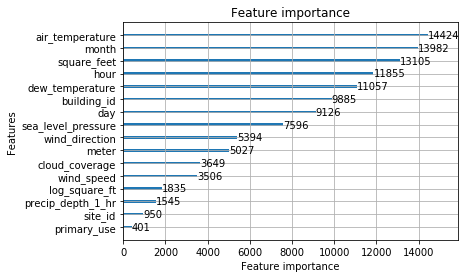

In [71]:
lgbm.plot_importance(model);

## LihtGBM, V.2

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

fill_nans(X_train)
fill_nans(X_test)

C:\Users\smouz\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:5797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [73]:
# drop categorical which contains strings
# X_train = X_train.drop(['primary_use'], axis=1)
# X_test = X_test.drop(['primary_use'], axis=1)

params = [{
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1700,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}]
    
params = [

    {
        **params[0],
        "num_leaves": 2000,
#         "feature_fraction": 0.85,
    },
    {
        **params[0],
        "num_leaves": 2100,
#         "feature_fraction": 0.9,
    },
    {
        **params[0],
        "num_leaves": 2200,
#         "feature_fraction": 0.95,
    },
]

all_models = []
for i in np.arange(1):
    print(f'Training model {i} ...')
    
    # instantiate model
    model = lgbm.LGBMRegressor(**params[i])
    
    # make pipeline
#     model = make_pipeline(
#         pca,
#         lgbm.LGBMRegressor(**params[2])
#     )
    
    # train model
    model.fit(X_train, y_train)
    
    # make predictions
    y_pred = model.predict(X_test)
    
    # print params and metric
#     print('PCA Components:', pca.n_components)
    print('num leaves:', params[i]['num_leaves'])
    print('Test RMSLE:', RMSLE(y_test, y_pred))
    print('Test RMSE:', MSE(y_test, y_pred, squared=False))
    print('=' * 75)
    print('\n')
    
#     all_models.append(model)

Training model 0 ...
num leaves: 2000
Test RMSLE: ('RMSLE', 1.593069213520383, False)
Test RMSE: 55692.69302937796




C:\Users\smouz\Anaconda3\envs\ashrae\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


## RandomForest

In [74]:
# OneHotEncoder??
# X.primary_use.cat.codes
X.shape

# remove categorical features to speed up trainings
# X_train = X_train.drop(['primary_use'], axis=1)
# X_test = X_test.drop(['primary_use'], axis=1)

(2012560, 16)

In [80]:

params = [{
        "n_estimators": 100,
        'n_jobs': -1,
        'random_state': 11
    }]

params = [
    {
        "n_estimators": 80,
        'n_jobs': -1,
        'random_state': 11
    },
    {
        **params[0],
        "n_estimators": 100,
    },
    {
        **params[0],
        "n_estimators": 115,
    }
]

In [81]:
# drop categorical column containing strings to speed up training
if X_train.columns.isin(['primary_use']).any():
    X_train = X_train.drop(['primary_use'], axis=1)
    X_test = X_test.drop(['primary_use'], axis=1)

pca = PCA(n_components=3, random_state=11)
for i in np.arange(1):
    print(f'Training model {i} ...')

    # instantiate model
    model = make_pipeline(
#         OneHotEncoder(),
        pca,
        RandomForestRegressor(**params[i])
    )
    
    
    # train model
    model.fit(X_train, y_train)
    
    # make predictions
    y_pred = model.predict(X_test)
    
    # print params and metric
    
    print('N estimators:', params[i]['n_estimators'])
    print('RMSLE:', RMSLE(y_test, y_pred))
    print('RMSE:', MSE(y_test, y_pred, squared=False))
    print('=' * 75)

Training model 0 ...

N estimators: 80
RMSLE: ('RMSLE', 1.8604531015027899, False)
RMSE: 167845.1635068772
